## Detect occupational bias in different sentiment models

At least check these:
* BERT Tone
* XLM Roberta
* Senda

Originally wanted to test a SpaCy model instead of the BERT-based model, but ended up dropping it due to poor classification performance on benchmark datasets.

Sources:
* https://www.kaggle.com/code/hamelg/python-for-data-26-anova
* https://www.pythonfordatascience.org/parametric-assumptions-python/
* https://www.pythonfordatascience.org/anova-python/
* https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html
* https://www.statology.org/dunns-test-python/
* https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
* https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb

### Pseudo-code and notes

I need data that contains the "predicted positive class probability" and the gender of the noun phrase for each of the 2,400 sentences. They should be in a df, each row representing a sentence. To get this, I need to run each model on the synthetic data.

**Consider lowering and removing the punctuation! No, both K&M and B&B use normal sentences (capital first letter, full stop at the end)**

In [1]:
# # another method
# # Etract individual groups
# asian = voter_age[groups["asian"]]
# black = voter_age[groups["black"]]
# hispanic = voter_age[groups["hispanic"]]
# other = voter_age[groups["other"]]
# white = voter_age[groups["white"]]

# # Perform the ANOVA
# stats.f_oneway(asian, black, hispanic, other, white)

### Imports

In [1]:
from danlp.models import load_bert_tone_model # BERT Tone
import operator # for the SpaCy model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline # for the XLM Roberta model and the SENDA model
from typing import List, Dict, Tuple
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols # ordinary least squares
import numpy as np
import researchpy as rp
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns
from statannotations.Annotator import Annotator
tqdm.pandas()

ALPHA = 0.05
IV = "gender" # should be Dtype = object
DV_POS = "pos_proba" # should be Dtype = float64
DV_NEU = "neu_proba" # should be Dtype = float64
DV_NEG = "neg_proba" # should be Dtype = float64
IV_order = ["F", "M", "Q"]

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# utils functions

# for use with roberta
def convert_to_label_score_dict(top_k_list:List[Dict[str,str]]) -> dict: 
    """Convert a list of top-k probabilities (each being a dict of label and score) into a dictionary of the format {label: score}.

    Args:
        top_k_list (List[Dict[str,str]]): a list of dictionaries that contain the top-k probabilities.

    Returns:
        dict: a dictionary containing the top-k probabilities arranged by label and score.
    """
    new_dict = {}
    for proba_dict in top_k_list:
        new_dict[proba_dict["label"].lower()] = proba_dict["score"]
    return new_dict

### Load models

In [3]:
# senda
senda_tokenizer = AutoTokenizer.from_pretrained("pin/senda")
senda_clf = AutoModelForSequenceClassification.from_pretrained("pin/senda")
senda_pipeline = pipeline("sentiment-analysis", model=senda_clf, tokenizer=senda_tokenizer)

# bert tone
bert_clf = load_bert_tone_model()

# roberta
roberta_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
roberta_clf = pipeline("text-classification", model=roberta_path, tokenizer=roberta_path)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.1.2+cpu)
    Python  3.9.13 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


### Load gender corpus

In [4]:
# load gender corpus
corpus = pd.read_excel("gender_corpus.xlsx")
corpus.head()

,identity_term_DA,identity_term_EN,gender,job_title_DA,job_title_EN,gender_distribution,sentence_DA,sentence_EN
0,androgynen,the androgynous person,Q,bager,baker,female-dominated,Androgynen er bager.,The androgynous person is a(n) baker.
1,androgynen,the androgynous person,Q,bibliotekar,librarian,female-dominated,Androgynen er bibliotekar.,The androgynous person is a(n) librarian.
2,androgynen,the androgynous person,Q,optiker,optician,female-dominated,Androgynen er optiker.,The androgynous person is a(n) optician.
3,androgynen,the androgynous person,Q,boghandler,bookseller,female-dominated,Androgynen er boghandler.,The androgynous person is a(n) bookseller.
4,androgynen,the androgynous person,Q,praktiserende læge,general practitioner,female-dominated,Androgynen er praktiserende læge.,The androgynous person is a(n) general practit...


### Predict the class probabilities

In [5]:
def predict_class_probas(data:pd.DataFrame, model, model_name:str) -> pd.DataFrame:
    """Predict the positive, neutral, and negative class probabilities using a provided sentiment analysis model.

    Args:
        data (pd.DataFrame): the sentences should be in the column with index 1.
        model: the sentiment analysis model
        model_name (str): the name/type of model. Options: ['spacy', 'bert_tone', 'roberta', 'senda'].

    Raises:
        Exception: If unknown model type is specified.

    Returns:
        pd.DataFrame: the data with the predicted class probabilities.
    """
    data["pos_proba"], data["neu_proba"], data["neg_proba"] = np.nan, np.nan, np.nan # initiate empty columns
    
    for i in tqdm(range(len(data))):
        sentence = data.iloc[i, 1]
        
        # score sentences using the specific system
        if model_name.lower() == "spacy":
            probas = model(sentence).cats
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        elif model_name.lower() == "bert_tone":
            pos, neu, neg = model.predict_proba(sentence)[0] # order can be seen using clf._classes() -- ['positive', 'neutral', 'negative']
        elif model_name.lower() == "roberta":
            probas_list = model(sentence, top_k=None) # list of top-k probas
            probas = convert_to_label_score_dict(probas_list) # convert to similar format as that of the spacy model
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        elif model_name.lower() == "senda":
            probas_list = model(sentence, top_k=None) # list of top-k probas
            probas = convert_to_label_score_dict(probas_list) # convert to similar format as that of the spacy model
            pos, neu, neg = probas["positiv"], probas["neutral"], probas["negativ"]
        else:
            raise Exception("Unrecognized model name. Choose 'spacy', 'bert_tone', 'roberta' or 'senda'.")
        
        # add to dataframe
        data.iloc[i, 2] = pos
        data.iloc[i, 3] = neu
        data.iloc[i, 4] = neg
    
    return data

In [6]:
# Senda (2-3 mins)

senda_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
senda_df = predict_class_probas(data=senda_df, model=senda_pipeline, model_name="senda")

senda_df.head()

100%|██████████| 2400/2400 [02:47<00:00, 14.36it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.052629,0.540688,0.406683
1,Q,Androgynen er bibliotekar.,0.368320,0.382355,0.249325
2,Q,Androgynen er optiker.,0.056737,0.752827,0.190435
3,Q,Androgynen er boghandler.,0.213640,0.557622,0.228738
4,Q,Androgynen er praktiserende læge.,0.211037,0.455978,0.332985


In [7]:
# BERT Tone (5-6 mins)

bert_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
bert_df = predict_class_probas(data=bert_df, model=bert_clf, model_name="bert_tone")

bert_df.head()

  0%|          | 0/2400 [00:00<?, ?it/s]

100%|██████████| 2400/2400 [05:58<00:00,  6.70it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.001226,0.997965,0.000809
1,Q,Androgynen er bibliotekar.,0.001020,0.998033,0.000946
2,Q,Androgynen er optiker.,0.001172,0.997997,0.000831
3,Q,Androgynen er boghandler.,0.000811,0.997627,0.001561
4,Q,Androgynen er praktiserende læge.,0.000447,0.998465,0.001088


In [8]:
# XLM Roberta (2-3 mins)

roberta_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
roberta_df = predict_class_probas(data=roberta_df, model=roberta_clf, model_name="roberta")

roberta_df.head()

  0%|          | 1/2400 [00:00<06:47,  5.89it/s]

100%|██████████| 2400/2400 [02:43<00:00, 14.71it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.006356,0.895560,0.098084
1,Q,Androgynen er bibliotekar.,0.008292,0.986916,0.004792
2,Q,Androgynen er optiker.,0.006736,0.989384,0.003880
3,Q,Androgynen er boghandler.,0.005188,0.989231,0.005580
4,Q,Androgynen er praktiserende læge.,0.008469,0.986922,0.004609


### ANOVAs and post-hoc tests

1) Fit model
2) Check assumptions
3) Conduct regular ANOVA or Kruskal-Wallis test
4) Conduct post-hoc tests and visualize results

#### Assumptions

**Independence**
* "This assumption is tested when the study is designed. What this means is that all groups are mutually exclusive, i.e. an individual can only belong in one group. Also, this means that the data is not repeated measures (not collected through time). In this example, this condition is met." - https://www.pythonfordatascience.org/anova-python/

**Normality**
* Absence of normality might not be a problem.
* *Central Limit Theorem*: "It means that if the sample size is large enough then normality may not be a concern even if the test for normality indicates that normality is not present. Simulation studies have been conducted and the general rule of thumb is n ≥ 30."
* But could also just choose a non-parametric test instead, if there's an absence of normality.
* "What if Normality is Violated?
* If the assumption of normality is violated fear not! There are a few routes to consider, these are in no particular order:
    * Rely on the Central Limit Theorem if the sample size is large enough (>= 30)
    * Use a non-parametric statistical test
    * Transform the data" 
* Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

**Homogeneity of variance**

* "What if homogeneity of variances is violated?
* If there is not equal variances between groups there are a few routes to consider, these are in no particular order:
    * Use a non-parametric statistical test
    * Transform the data"
* Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

**Bonferroni-corrected alpha for post-hoc tests**

* Instead, I will correct the p-values by multiplying them with 3 (number of comparisons: F-M, M-Q, F-Q) as it produces the same result but is easier to interpret for the visualizations. If I want to follow the other approach instead later, I should look in the version of this notebook with the "_draft" suffix.

#### Functions

In [9]:
# functions to check assumptions
def check_normality(model, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if normality assumption is satisfied."""
    res = stats.shapiro(model.resid) # (W-test statistic, p-value)
    satisfied = res.pvalue >= alpha
    
    if plot:
        fig = plt.figure(figsize=(4,4))
        normality_plot, stat = stats.probplot(model.resid, plot=plt, rvalue=True)
        plt.title("Probability plot of model residuals")
        plt.show()
        
    return satisfied, res

def check_homogeneity(data, proba_colname, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if homogeneity of variance assumption is satisfied."""
    res = stats.levene(
        data[proba_colname][data["gender"] == "F"],
        data[proba_colname][data["gender"] == "M"],
        data[proba_colname][data["gender"] == "Q"]
        )
    satisfied = res.pvalue >= alpha
    
    if plot:
        plt.figure(figsize=(4,4))
        plot_data = [data[proba_colname][data["gender"] == "F"],
                data[proba_colname][data["gender"] == "M"],
                data[proba_colname][data["gender"] == "Q"]]
        plt.boxplot(plot_data, labels=['female', 'male', 'other'], showmeans=True)
        plt.title(f"Boxplot of {proba_colname} by gender")
        plt.xlabel("Gender")
        plt.ylabel("Predicted positive class probability")
        plt.show()
        
    return satisfied, res

In [10]:
# omnibus test function

def statistical_testing(data, dv, iv, alpha, plot_bool) -> tuple:
    """Inspect data, check assumptions and perform omnibus test (ANOVA or Kruskal-Wallis). Returns tuple with (test_type, test_statistic, p_value, significant_bool)"""
    # inspect data (overall and by gender)
    print("Raw data:")
    display(rp.summary_cont(data[dv]))
    display(rp.summary_cont(data[dv].groupby(data[iv])))    

    # inspect ranks
    print("Ranks:")
    data["ranks"] = stats.rankdata(data[dv])
    display(rp.summary_cont(data["ranks"].groupby(data[iv]))) 
    
    # define and fit model
    model = ols(f"{dv} ~ {iv}", data=data).fit() # fit model

    # check assumptions
    # independence - assumed OK

    # normality 
    normality, n_res = check_normality(model, alpha, plot=plot_bool)
    print("Normality assumption satisfied:", normality)
    print(n_res)

    # homogeneity of variance
    homogeneity, h_res = check_homogeneity(data, dv, plot=plot_bool)    
    print("Homogeneity assumption satisfied:", homogeneity)
    print(h_res)

    # statistical testing
    # divide data by gender
    female = data[data[iv] == "F"]
    male = data[data[iv] == "M"]
    queer = data[data[iv] == "Q"]

    # omnibus test
    if normality == False or homogeneity == False: # if at least one assumption is not met:
        print("\nASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨") # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/
        test_type = "kruskal-wallis"
        test_statistic, p = stats.kruskal(female[dv], male[dv], queer[dv]) # test statistic is called "H" here
        ranks_stat, ranks_p = stats.kruskal(female["ranks"], male["ranks"], queer["ranks"])
        assert (test_statistic, p) == (ranks_stat, ranks_p) # if this is true, then the ranks are the same that are used for the calculation above
    elif normality == True and homogeneity == True:
        print("\nALL ASSUMPTIONS MET --> ✨ ANOVA ✨")
        test_type = "anova"
        test_statistic, p = stats.f_oneway(female, male, queer) # test statistic is called "F" here
    print("statistic =", test_statistic)
    print("p =", p)
    print("✨ significant =", p < alpha, "✨")
    print()

    return (test_type, test_statistic, p, p < alpha)

In [11]:
# visualization functions
def correlation_matrix_to_pairwise_table(pvalues:pd.DataFrame) -> pd.DataFrame:
    """Convert pvalues from format similar to a correlation matrix to a table of pairwise results."""

    # replace redundant comparisons with NaNs
    remove = np.tril(np.ones(pvalues.shape), k=0).astype("bool")
    pvalues[remove] = np.nan 

    # melt df
    molten_df = pvalues.melt(ignore_index=False).reset_index().dropna()
    
    return molten_df

def plot_single_dunn_results(data:pd.DataFrame, results:pd.DataFrame, model_name:str, text_format:str="star", ylims:List[int]=[None,None]) -> None:
    """Plot results of a single dunn-test."""
    # based on: https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
    
    # prepare plot
    ax = sns.boxplot(data=data, x=IV, y=DV, order=IV_order)

    # prepare results
    molten_res = correlation_matrix_to_pairwise_table(results)
    pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_res.iterrows()]
    p_values = [i[1]["value"] for i in molten_res.iterrows()]

    # annotate plot
    annotator = Annotator(ax, pairs, data=data, x=IV, y=DV, order=IV_order)
    annotator.configure(text_format=text_format, loc="inside")
    annotator.set_pvalues_and_annotate(p_values)

    # other plot configurations
    plt.title(f"{model_name}: Predicted neutral class probability by NP gender")
    plt.xlabel("Gender")
    plt.ylabel("Neutral class probability")
    plt.xticks(ticks=[0,1,2], labels=["Female", "Male", "Other"])
    plt.ylim(ylims)
    plt.tight_layout()
    plt.show()

def plot_multiple_dunn_results(data:pd.DataFrame, results:pd.DataFrame, dv:str,  hue_order:List[str], pred_class:str, model_order:List[str], text_format:str="star", ylims:List[int]=[None,None], figsize:Tuple[int]=(6,6)) -> None:
    """Plot results of multiple dunn-tests.
    x = model, y = DV, hue = IV"""
    # based on: https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
    
    # prepare plot
    plt.figure(figsize=figsize) # (width, length)
    my_cmap = plt.get_cmap("Set1").colors[1:4]
    ax = sns.boxplot(data=data, x="model", y=dv, order=model_order, hue=IV, hue_order=hue_order, palette=my_cmap)

    # prepare data
    all_pairs = [((i[1]["model"], i[1]["index"]), (i[1]["model"], i[1]["variable"])) for i in results.iterrows()]
    all_pvalues = [i[1]["value"] for i in results.iterrows()]

    # annotate plot
    annotator = Annotator(ax, all_pairs, data=data, x="model", y=dv, order=model_order, hue=IV, hue_order=hue_order)
    annotator.configure(text_format=text_format, loc="inside", color="k")
    annotator.set_pvalues_and_annotate(all_pvalues)

    # other plot configurations
    plt.title(f"Predicted {pred_class.lower()} class probability by NP gender")
    plt.xlabel("Model")
    plt.ylabel(f"{pred_class.capitalize()} class probability")
    plt.ylim(ylims)
    plt.tight_layout()
    plt.show()

In [12]:
# variables for plots
model_data = {"Senda":senda_df, "BERT Tone":bert_df, "XLM Roberta":roberta_df}
model_order = model_data.keys()

# all data
senda_df["model"] = "Senda"
bert_df["model"] = "BERT Tone"
roberta_df["model"] = "XLM Roberta"
all_df = pd.concat([senda_df, bert_df, roberta_df])
all_df.head()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model
0,Q,Androgynen er bager.,0.052629,0.540688,0.406683,Senda
1,Q,Androgynen er bibliotekar.,0.368320,0.382355,0.249325,Senda
2,Q,Androgynen er optiker.,0.056737,0.752827,0.190435,Senda
3,Q,Androgynen er boghandler.,0.213640,0.557622,0.228738,Senda
4,Q,Androgynen er praktiserende læge.,0.211037,0.455978,0.332985,Senda


I think it makes more sense to do it per dependent variable, instead of per model. 

So instead I do something like:

```
positive dv:

for model in models:
    check data types
    print some stats (for this dv!)
    define model
    check assumptions
    do omnibus testing
    save results
    if omnibus == significant and type == "kruskal-wallis":
        then do dunn-test
        save results

afterwards,
make plot for the dunn results for this dependent variable
```

#### Neutral class probabilities

In [13]:
model_data.keys()

dict_keys(['Senda', 'BERT Tone', 'XLM Roberta'])

In [14]:
all_posthoc_res_NEU = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_NEU, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_NEU, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_NEU.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")
    else:
        print("No posthoc tests needed as the result of the omnibus test is not significant!")

all_posthoc_res_NEU = pd.concat(all_posthoc_res_NEU)

__________________________________________________
Current model = Senda
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.5421,0.1183,0.0024,0.5374,0.5469


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.5513,0.1054,0.0037,0.5440,0.5586
M,800,0.5465,0.1139,0.0040,0.5386,0.5544
Q,800,0.5286,0.1327,0.0047,0.5194,0.5378


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1243.8888,654.5860,23.1431,1198.4603,1289.3172
M,800,1214.9025,689.8177,24.3887,1167.0289,1262.7761
Q,800,1142.7088,729.4066,25.7884,1092.0877,1193.3298


Normality assumption satisfied: False
ShapiroResult(statistic=0.9958859086036682, pvalue=3.687213620651164e-06)
Homogeneity assumption satisfied: False
LeveneResult(statistic=16.80944230498689, pvalue=5.629537434272956e-08)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 9.045971194293088
p = 0.010856561913535649
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.9232,0.2327,0.0047,0.9139,0.9325


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9774,0.0819,0.0029,0.9717,0.9831
M,800,0.9915,0.0315,0.0011,0.9893,0.9936
Q,800,0.8007,0.3636,0.0129,0.7755,0.8260


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1167.7869,625.9498,22.1307,1124.3458,1211.2280
M,800,1429.0225,606.5743,21.4456,1386.9261,1471.1189
Q,800,1004.6906,768.3149,27.1640,951.3693,1058.0119


Normality assumption satisfied: False
ShapiroResult(statistic=0.5974825620651245, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=194.2503695860746, pvalue=6.539733584087565e-79)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 152.6597160546724
p = 7.085391537261428e-34
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.9246,0.2021,0.0041,0.9165,0.9326


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9171,0.2188,0.0077,0.9019,0.9323
M,800,0.9191,0.2123,0.0075,0.9044,0.9338
Q,800,0.9375,0.1715,0.0061,0.9256,0.9494


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1098.5506,650.7548,23.0077,1053.3880,1143.7132
M,800,1268.8369,698.8557,24.7083,1220.3361,1317.3377
Q,800,1234.1125,716.7336,25.3404,1184.3710,1283.8540


Normality assumption satisfied: False
ShapiroResult(statistic=0.370566725730896, pvalue=0.0)
Homogeneity assumption satisfied: True
LeveneResult(statistic=2.3694278362295766, pvalue=0.0937532689625198)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 26.9777657185969
p = 1.3862852652392724e-06
✨ significant = True ✨



In [15]:
# for illustrative purposes, this version gets the same results
# roberta, neutral class

from pingouin import kruskal
kruskal(data=roberta_df, dv=DV_NEU, between=IV)

,Source,ddof1,H,p-unc
Kruskal,gender,2,26.977766,0.000001


In [72]:
# # get ranks
# # https://www.thesecuritybuddy.com/statistics-for-machine-learning/how-to-rank-data-using-python/
# roberta_df_copy = roberta_df.copy()
# roberta_df_copy["neu_ranks"] = stats.rankdata(roberta_df["neu_proba"])
# display(roberta_df_copy.head())

# # if we perform the test on the ranks, we get the same results, so these are the correct ranks!
# display(kruskal(data=roberta_df_copy, dv="neu_ranks", between=IV))

# # mean ranks
# display(rp.summary_cont(roberta_df_copy["neu_ranks"].groupby(roberta_df_copy[IV]))) 

In [16]:
print("Results of posthoc tests:")
all_posthoc_res_NEU

Results of posthoc tests:


,index,variable,value,model
3,F,M,1.000000e+00,Senda
6,F,Q,1.049398e-02,Senda
7,M,Q,1.115842e-01,Senda
3,F,M,1.413678e-13,BERT Tone
6,F,Q,7.534176e-06,BERT Tone
7,M,Q,5.239132e-34,BERT Tone
3,F,M,2.667326e-06,XLM Roberta
6,F,Q,2.740148e-04,XLM Roberta
7,M,Q,9.487445e-01,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:5.239e-34
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:2.667e-06
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:9.487e-01
Senda_F vs. Senda_M: Custom statistical test, P_val:1.000e+00
Senda_M vs. Senda_Q: Custom statistical test, P_val:1.116e-01
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:1.414e-13
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:2.740e-04
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:7.534e-06
Senda_F vs. Senda_Q: Custom statistical test, P_val:1.049e-02


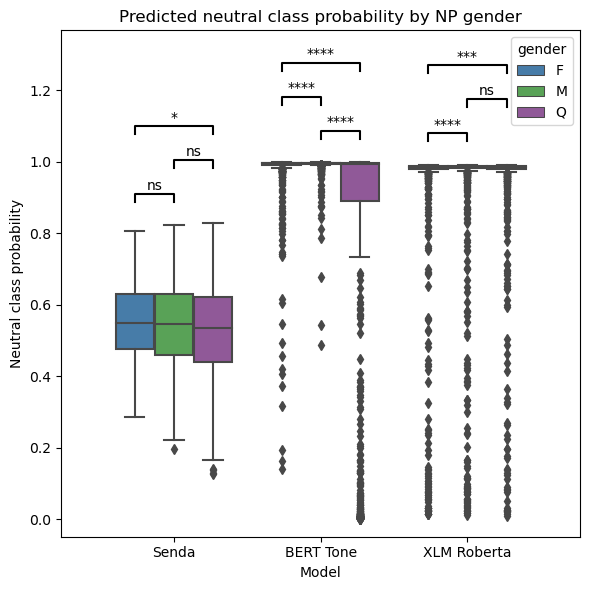

In [17]:
plot_multiple_dunn_results(all_df, all_posthoc_res_NEU, DV_NEU, ["F", "M", "Q"], "NEUTRAL", model_order)

In [40]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_NEU, DV_NEU, ["F", "M", "Q"], "NEUTRAL", model_order, ylims=(.9, 1.2))

#### Positive class probabilities

In [18]:
all_posthoc_res_POS = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_POS, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_POS, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_POS.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")
    else:
        print("No posthoc tests needed as the result of the omnibus test is not significant!")

all_posthoc_res_POS = pd.concat(all_posthoc_res_POS)

__________________________________________________
Current model = Senda
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.2115,0.1047,0.0021,0.2073,0.2157


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.2002,0.0913,0.0032,0.1938,0.2065
M,800,0.2324,0.1022,0.0036,0.2253,0.2395
Q,800,0.2020,0.1162,0.0041,0.1940,0.2101


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1151.5275,645.8295,22.8335,1106.7067,1196.3483
M,800,1358.5363,652.7979,23.0799,1313.2319,1403.8406
Q,800,1091.4362,747.8257,26.4396,1039.5369,1143.3356


Normality assumption satisfied: False
ShapiroResult(statistic=0.9471493363380432, pvalue=1.5340211359270405e-28)
Homogeneity assumption satisfied: False
LeveneResult(statistic=14.39231429541816, pvalue=6.119690484047891e-07)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 65.42051417638504
p = 6.224663014808551e-15
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.0339,0.1529,0.0031,0.0278,0.04


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0115,0.0549,0.0019,0.0077,0.0153
M,800,0.0039,0.0149,0.0005,0.0029,0.0049
Q,800,0.0862,0.2506,0.0089,0.0688,0.1036


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1303.1462,655.4109,23.1723,1257.6605,1348.6320
M,800,1052.6638,625.9321,22.1300,1009.2239,1096.1036
Q,800,1245.6900,765.4871,27.0641,1192.5649,1298.8151


Normality assumption satisfied: False
ShapiroResult(statistic=0.37069010734558105, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=75.4285557023982, pvalue=1.703410943736015e-32)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 57.36600675239515
p = 3.4924476847536413e-13
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.0194,0.0856,0.0017,0.016,0.0229


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0268,0.1090,0.0039,0.0192,0.0343
M,800,0.0238,0.0995,0.0035,0.0169,0.0307
Q,800,0.0077,0.0038,0.0001,0.0075,0.0080


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1424.7712,699.6698,24.7371,1376.2139,1473.3286
M,800,1257.6750,689.7104,24.3849,1209.8089,1305.5411
Q,800,919.0538,586.1902,20.7250,878.3720,959.7355


Normality assumption satisfied: False
ShapiroResult(statistic=0.15974891185760498, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=10.373362988661802, pvalue=3.2680626024319974e-05)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 221.20544080070704
p = 9.243763947699207e-49
✨ significant = True ✨



In [19]:
print("Results of posthoc tests:")
all_posthoc_res_POS

Results of posthoc tests:


,index,variable,value,model
3,F,M,6.920371e-09,Senda
6,F,Q,2.485820e-01,Senda
7,M,Q,3.806996e-14,Senda
3,F,M,1.456459e-12,BERT Tone
6,F,Q,2.917867e-01,BERT Tone
7,M,Q,7.597247e-08,BERT Tone
3,F,M,4.249932e-06,XLM Roberta
6,F,Q,8.965082e-48,XLM Roberta
7,M,Q,4.405855e-22,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:7.597e-08
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:4.250e-06
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:4.406e-22
Senda_F vs. Senda_M: Custom statistical test, P_val:6.920e-09
Senda_M vs. Senda_Q: Custom statistical test, P_val:3.807e-14
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:1.456e-12
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:8.965e-48
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:2.918e-01
Senda_F vs. Senda_Q: Custom statistical test, P_val:2.486e-01


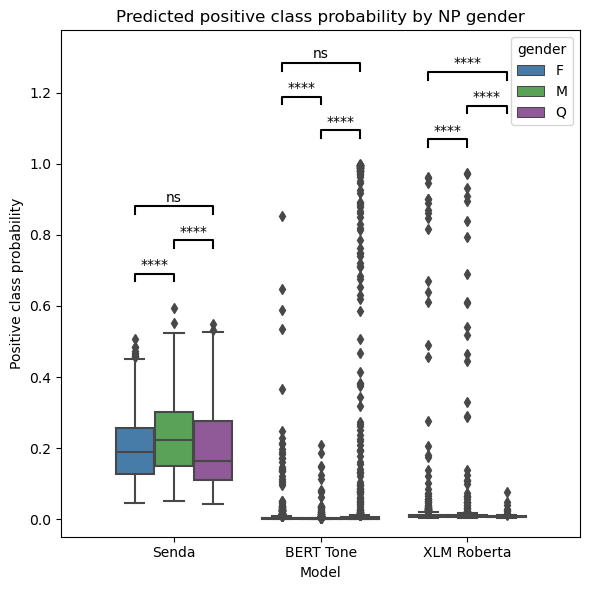

In [20]:
plot_multiple_dunn_results(all_df, all_posthoc_res_POS, DV_POS, ["F", "M", "Q"], "POSITIVE", model_order)

In [39]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_POS, DV_POS, ["F", "M", "Q"], "POSITIVE", model_order, ylims=(0, 0.05))

#### Negative class probabilities

In [21]:
all_posthoc_res_NEG = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_NEG, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_NEG, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_NEG.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")
    else:
        print("No posthoc tests needed as the result of the omnibus test is not significant!")

all_posthoc_res_NEG = pd.concat(all_posthoc_res_NEG)

__________________________________________________
Current model = Senda
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.2463,0.0963,0.002,0.2425,0.2502


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.2485,0.0752,0.0027,0.2433,0.2537
M,800,0.2211,0.0767,0.0027,0.2158,0.2264
Q,800,0.2694,0.1231,0.0044,0.2608,0.2779


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1286.9812,652.2383,23.0601,1241.7157,1332.2468
M,800,1001.1600,628.1759,22.2094,957.5644,1044.7556
Q,800,1313.3588,749.5029,26.4989,1261.3430,1365.3745


Normality assumption satisfied: False
ShapiroResult(statistic=0.8727740049362183, pvalue=1.7462140683337275e-40)
Homogeneity assumption satisfied: False
LeveneResult(statistic=55.038435440800505, pvalue=4.262946631561701e-24)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 99.87928305393507
p = 2.0487513682080936e-22
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.0429,0.1672,0.0034,0.0362,0.0496


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0111,0.0589,0.0021,0.0070,0.0152
M,800,0.0046,0.0268,0.0009,0.0028,0.0065
Q,800,0.1130,0.2689,0.0095,0.0944,0.1317


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1179.7012,649.2052,22.9529,1134.6462,1224.7563
M,800,1001.4025,621.2841,21.9657,958.2852,1044.5198
Q,800,1420.3962,738.7849,26.1200,1369.1243,1471.6682


Normality assumption satisfied: False
ShapiroResult(statistic=0.45250290632247925, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=115.74171600506826, pvalue=1.0361055018216848e-48)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 147.3165568877548
p = 1.0247457488639225e-32
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.056,0.1834,0.0037,0.0487,0.0633


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0561,0.1913,0.0068,0.0428,0.0694
M,800,0.0571,0.1874,0.0066,0.0441,0.0701
Q,800,0.0548,0.1710,0.0060,0.0429,0.0667


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1067.8625,702.6512,24.8425,1019.0983,1116.6267
M,800,1067.2150,726.3966,25.6820,1016.8028,1117.6272
Q,800,1466.4225,560.5588,19.8187,1427.5195,1505.3255


Normality assumption satisfied: False
ShapiroResult(statistic=0.3164955973625183, pvalue=0.0)
Homogeneity assumption satisfied: True
LeveneResult(statistic=0.07980020820468879, pvalue=0.9233032486974384)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 176.71365870470618
p = 4.2375669602672096e-39
✨ significant = True ✨



In [22]:
print("Results of posthoc tests:")
all_posthoc_res_NEG

Results of posthoc tests:


,index,variable,value,model
3,F,M,4.782536e-16,Senda
6,F,Q,1.000000e+00,Senda
7,M,Q,6.152193e-19,Senda
3,F,M,7.984276e-07,BERT Tone
6,F,Q,1.120843e-11,BERT Tone
7,M,Q,3.459160e-33,BERT Tone
3,F,M,1.000000e+00,XLM Roberta
6,F,Q,3.820490e-30,XLM Roberta
7,M,Q,3.076023e-30,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:3.459e-33
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:1.000e+00
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:3.076e-30
Senda_F vs. Senda_M: Custom statistical test, P_val:4.783e-16
Senda_M vs. Senda_Q: Custom statistical test, P_val:6.152e-19
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:7.984e-07
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:3.820e-30
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:1.121e-11
Senda_F vs. Senda_Q: Custom statistical test, P_val:1.000e+00


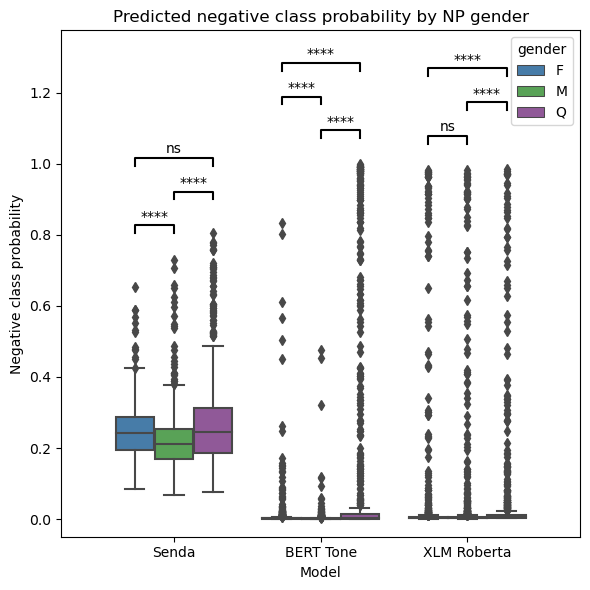

In [23]:
plot_multiple_dunn_results(all_df, all_posthoc_res_NEG, DV_NEG, ["F", "M", "Q"], "NEGATIVE", model_order)

In [42]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_NEG, DV_NEG, ["F", "M", "Q"], "NEGATIVE", model_order, ylims=(0.0, 0.05))

## Testing things here 

### Get examples of ratings

In [24]:
frisør_sents = ["Min far er frisør.", "Min mor er frisør.", "Min nonbinære forælder er frisør."]

In [25]:
senda_df[senda_df["sentence_DA"].isin(frisør_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
1507,M,Min far er frisør.,0.235188,0.482152,0.282660,Senda,1794.0
1757,F,Min mor er frisør.,0.199245,0.505644,0.295111,Senda,1899.0
1807,Q,Min nonbinære forælder er frisør.,0.251613,0.495062,0.253324,Senda,1475.0


In [26]:
bert_df[bert_df["sentence_DA"].isin(frisør_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
1507,M,Min far er frisør.,0.004028,0.994163,0.001809,BERT Tone,1167.0
1757,F,Min mor er frisør.,0.005377,0.992335,0.002288,BERT Tone,1438.0
1807,Q,Min nonbinære forælder er frisør.,0.010348,0.588201,0.401452,BERT Tone,2298.0


In [27]:
roberta_df[roberta_df["sentence_DA"].isin(frisør_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
1507,M,Min far er frisør.,0.011548,0.985794,0.002658,XLM Roberta,374.0
1757,F,Min mor er frisør.,0.013221,0.983753,0.003027,XLM Roberta,578.0
1807,Q,Min nonbinære forælder er frisør.,0.007395,0.987632,0.004973,XLM Roberta,1383.0


In [28]:
elektriker_sents = ["Denne kvinde er elektriker.", "Denne mand er elektriker.", "Denne tvekønnede person er elektriker."]

In [29]:
senda_df[senda_df["sentence_DA"].isin(elektriker_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
318,F,Denne kvinde er elektriker.,0.080191,0.516844,0.402965,Senda,2280.0
368,M,Denne mand er elektriker.,0.217587,0.562368,0.220045,Senda,1062.0
668,Q,Denne tvekønnede person er elektriker.,0.231959,0.489051,0.278990,Senda,1766.0


In [30]:
bert_df[bert_df["sentence_DA"].isin(elektriker_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
318,F,Denne kvinde er elektriker.,0.113406,0.742791,0.143803,BERT Tone,2258.0
368,M,Denne mand er elektriker.,0.001961,0.997013,0.001026,BERT Tone,405.0
668,Q,Denne tvekønnede person er elektriker.,0.000930,0.997012,0.002058,BERT Tone,1311.0


In [31]:
roberta_df[roberta_df["sentence_DA"].isin(elektriker_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
318,F,Denne kvinde er elektriker.,0.011775,0.984689,0.003537,XLM Roberta,830.0
368,M,Denne mand er elektriker.,0.008099,0.987958,0.003943,XLM Roberta,1004.0
668,Q,Denne tvekønnede person er elektriker.,0.006240,0.982686,0.011074,XLM Roberta,1902.0


In [32]:
møbelhandler_sents = ["Hun er møbelhandler.", "Han er møbelhandler.", "Hen er møbelhandler."]

In [33]:
senda_df[senda_df["sentence_DA"].isin(møbelhandler_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
930,M,Han er møbelhandler.,0.144466,0.690593,0.164940,Senda,377.0
1030,Q,Hen er møbelhandler.,0.210028,0.595449,0.194523,Senda,742.0
1130,F,Hun er møbelhandler.,0.144450,0.625835,0.229716,Senda,1172.0


In [34]:
bert_df[bert_df["sentence_DA"].isin(møbelhandler_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
930,M,Han er møbelhandler.,0.001863,0.997136,0.001001,BERT Tone,384.0
1030,Q,Hen er møbelhandler.,0.001580,0.995911,0.002509,BERT Tone,1523.0
1130,F,Hun er møbelhandler.,0.002325,0.996622,0.001053,BERT Tone,442.0


In [35]:
roberta_df[roberta_df["sentence_DA"].isin(møbelhandler_sents)].copy()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model,ranks
930,M,Han er møbelhandler.,0.006496,0.990308,0.003196,XLM Roberta,664.0
1030,Q,Hen er møbelhandler.,0.006462,0.990325,0.003213,XLM Roberta,673.0
1130,F,Hun er møbelhandler.,0.007893,0.989086,0.003021,XLM Roberta,577.0


### Get top-3 highest positive and top-3 highest negative professions (across sentences)

In [36]:
# add job title and identity term back into dfs
senda_df["job_title"] = corpus["job_title_DA"]
senda_df["identity_term"] = corpus["identity_term_DA"]

bert_df["job_title"] = corpus["job_title_DA"]
bert_df["identity_term"] = corpus["identity_term_DA"]

roberta_df["job_title"] = corpus["job_title_DA"]
roberta_df["identity_term"] = corpus["identity_term_DA"]

In [37]:
# SENDA
senda_means_job = senda_df.groupby("job_title").mean(numeric_only=True)

print("Top-3 positive:")
display(senda_means_job.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(senda_means_job.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(senda_means_job.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
blomsterhandler,0.354061,0.438906,0.207034,873.291667
event- og udstillingsmedarbejder,0.345722,0.499501,0.154777,360.916667
vinduespudser,0.319073,0.488709,0.192218,691.062500


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
cater,0.179754,0.488295,0.331952,1713.375000
smed,0.144095,0.526895,0.329010,1632.916667
bager,0.192864,0.505729,0.301407,1578.458333


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
taxichauffør,0.125533,0.667600,0.206867,836.979167
buschauffør,0.132829,0.648864,0.218308,961.416667
fagforeningsmedarbejder,0.121897,0.642947,0.235157,1035.812500


In [38]:
# BERT TONE 
bert_means_job = bert_df.groupby("job_title").mean(numeric_only=True)

print("Top-3 positive:")
display(bert_means_job.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(bert_means_job.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(bert_means_job.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
arkitekt,0.151536,0.807680,0.040784,1148.625000
tjener,0.102936,0.860771,0.036293,1250.833333
frisør,0.063676,0.914349,0.021974,1319.604167


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
smed,0.031281,0.826082,0.142636,1753.8125
soldat,0.006998,0.860292,0.132710,1730.3125
cater,0.052839,0.828758,0.118403,1825.5625


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
vikar,0.004175,0.980010,0.015815,1114.270833
programmør,0.008098,0.974652,0.017249,509.208333
markedsanalytiker,0.006643,0.973371,0.019986,1039.020833


In [39]:
# XLM Roberta 
roberta_means_job = roberta_df.groupby("job_title").mean(numeric_only=True)

print("Top-3 positive:")
display(roberta_means_job.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(roberta_means_job.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(roberta_means_job.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
tjener,0.160241,0.791834,0.047926,1173.291667
guldsmed,0.143749,0.788820,0.067431,1347.333333
cater,0.108453,0.666828,0.224719,2052.854167


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
murer,0.007388,0.557404,0.435208,2166.270833
vikar,0.008209,0.675198,0.316593,2168.937500
bager,0.020543,0.695960,0.283497,1753.395833


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
job_title,,,,
naturvidenskabelig forsker,0.009073,0.988187,0.002740,397.687500
skotøjshandler,0.008401,0.987733,0.003866,732.875000
bankrådgiver,0.008300,0.987387,0.004313,960.520833


In [40]:
corpus[["job_title_DA", "gender_distribution"]].groupby("job_title_DA").describe().sort_values(by="job_title_DA")

gender_distribution         \
                                               count unique   
job_title_DA                                                  
SFO-pædagog                                       48      1   
VVS'er                                            48      1   
arkitekt                                          48      1   
bager                                             48      1   
bankrådgiver                                      48      1   
bibliotekar                                       48      1   
blomsterhandler                                   48      1   
boghandler                                        48      1   
brandmand                                         48      1   
buschauffør                                       48      1   
børnehavepædagog                                  48      1   
cater                                             48      1   
dagplejemor                                       48      1   
dyrlæge                                           48      1   
elektriker                                        48      1   
event- og udstillingsmedarbejder                  48      1   
fagforeningsmedarbejder                           48      1   
flyttemand                                        48      1   
fotograf                                          48      1   
frisør                                            48      1   
glarmester                                        48      1   
grafiker                                          48      1   
guldsmed                                          48      1   
hjemmehjælper                                     48      1   
humanistisk forsker                               48      1   
jordemoder                                        48      1   
kassemedarbejder                                  48      1   
købmand                                           48      1   
lokomotivfører                                    48      1   
markedsanalytiker                                 48      1   
murer                                             48      1   
møbelhandler                                      48      1   
naturvidenskabelig forsker                        48      1   
optiker                                           48      1   
pilot                                             48      1   
politibetjent                                     48      1   
praktiserende læge                                48      1   
programmør                                        48      1   
rejsearrangør                                     48      1   
skotøjshandler                                    48      1   
smed                                              48      1   
soldat                                            48      1   
tagdækker                                         48      1   
tandlæge                                          48      1   
taxichauffør                                      48      1   
tjener                                            48      1   
tømrer                                            48      1   
vaskerimedarbejder                                48      1   
vikar                                             48      1   
vinduespudser                                     48      1   

                                                                  
                                                        top freq  
job_title_DA                                                      
SFO-pædagog                       slightly female-dominated   48  
VVS'er                                       male-dominated   48  
arkitekt                            slightly male-dominated   48  
bager                                      female-dominated   48  
bankrådgiver                                        neutral   48  
bibliotekar                                female-dominated   48  
blomsterhandler                            female-dominated   48  
boghandler             

### Get top-3 highest positive and top-3 highest negative NPs (across sentences)

In [41]:
# SENDA
senda_means_np = senda_df.groupby("identity_term").mean(numeric_only=True)

print("Top-3 positive:")
display(senda_means_np.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(senda_means_np.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(senda_means_np.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
min genderqueer ven,0.377136,0.478228,0.144636,243.14
min bror,0.343190,0.438350,0.218460,1039.28
min bedstefar,0.323192,0.452001,0.224807,1106.02


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
min intetkønnede kollega,0.110815,0.283666,0.605519,2344.22
dette mandfolk,0.117124,0.539830,0.343046,1693.88
dette transkønnede individ,0.136657,0.549174,0.314169,1827.56


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
svigerdatteren,0.168153,0.667364,0.164482,462.00
denne transseksuelle medarbejder,0.134002,0.658316,0.207682,923.02
mit ikkebinære barn,0.107672,0.649538,0.242789,1265.50


In [42]:
# BERT TONE 
bert_means_np = bert_df.groupby("identity_term").mean(numeric_only=True)

print("Top-3 positive:")
display(bert_means_np.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(bert_means_np.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(bert_means_np.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
dette interkønnede individ,0.817687,0.148181,0.034132,1454.38
min intetkønnede kollega,0.436938,0.035358,0.527703,2301.52
denne kvinde,0.064353,0.866709,0.068938,1776.80


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
min nonbinære forælder,0.002415,0.396523,0.601063,2237.88
min intetkønnede kollega,0.436938,0.035358,0.527703,2301.52
mit ikkebinære barn,0.018726,0.599737,0.381537,2118.76


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
svigersønnen,0.001377,0.997430,0.001193,562.36
androgynen,0.001819,0.997145,0.001036,407.22
min husbond,0.001377,0.996886,0.001737,853.62


In [43]:
# XLM Roberta 
roberta_means_np = roberta_df.groupby("identity_term").mean(numeric_only=True)

print("Top-3 positive:")
display(roberta_means_np.sort_values(by="pos_proba", ascending=False).head(3))

print("Top-3 negative:")
display(roberta_means_np.sort_values(by="neg_proba", ascending=False).head(3))

print("Top-3 neutral:")
display(roberta_means_np.sort_values(by="neu_proba", ascending=False).head(3))

Top-3 positive:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
denne herre,0.138162,0.755888,0.105950,1142.26
denne dame,0.091528,0.773471,0.135001,1218.26
denne kvinde,0.081738,0.808241,0.110022,1259.66


Top-3 negative:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
dette mandfolk,0.011617,0.620340,0.368044,2131.58
dette kvindfolk,0.014792,0.715601,0.269607,1943.64
denne tvekønnede person,0.008526,0.735313,0.256161,2067.58


Top-3 neutral:


,pos_proba,neu_proba,neg_proba,ranks
identity_term,,,,
min genderqueer ven,0.006506,0.987997,0.005497,1085.24
min bror,0.010100,0.986435,0.003465,478.76
svigerdatteren,0.006921,0.986108,0.006971,1274.34
